# Basic Julia

# Install packages
Julia is very modular, with packages depending on and extending each other.
In Julia, there is not a single package that does all geospatial analysis like R's terra. Instead, you get to choose which functionality you need and install those packages.

Julia comes with a built-in environment and package manager. It will figure out which versions of packages are compatible with each other and install those. To use the package manager, use `]` followed by a command.

We will use the following packages:
- Rasters, for raster data analysis
- GeoDataFrames, for conveniently handling vector data
- CairoMakie, which is a great plotting library
- RasterDataSources, which is a convenient way to download raster data to your computer
- GADM, which we use to download administrative data (county boundaries etc)
- ArchGDAL, which is built on top of the GDAL library, and is necessary for loading .tif files

Executing this takes a few minutes - it will install all the packages and precompile them.


In [3]:
import Pkg # The package manager is itself a package
Pkg.activate(".") # Activate the current directory as a package environment
Pkg.instantiate() # Install dependencies

  Activating project at `c:\Users\tsh371\Documents\julia-workshop`
Precompiling project...
   5525.9 ms  ✓ FieldMetadata
   6560.0 ms  ✓ Setfield
   5057.1 ms  ✓ StableTasks
   5891.8 ms  ✓ Interfaces
   5101.6 ms  ✓ ArrayInterface
   1876.7 ms  ✓ Flatten
   3448.6 ms  ✓ CFTime
   3268.4 ms  ✓ CoordinateTransformations
   2627.2 ms  ✓ GeometryOpsCore
   1891.9 ms  ✓ ArrayInterface → ArrayInterfaceSparseArraysExt
   1449.3 ms  ✓ ArrayInterface → ArrayInterfaceStaticArraysCoreExt
   1635.8 ms  ✓ ArrayInterface → ArrayInterfaceChainRulesCoreExt
   2565.8 ms  ✓ CommonDataModel
   3067.7 ms  ✓ Proj
  20470.9 ms  ✓ HTTP
  18748.3 ms  ✓ DimensionalData
   5630.4 ms  ✓ FileIO → HTTPExt
   5902.3 ms  ✓ DataDeps
   3921.0 ms  ✓ DimensionalData → DimensionalDataDiskArraysExt
   5299.6 ms  ✓ DimensionalData → DimensionalDataStatsBase
   5664.4 ms  ✓ GADM
  13362.8 ms  ✓ DimensionalData → DimensionalDataMakie
   9477.9 ms  ✓ Rasters
   3485.7 ms  ✓ Rasters → RastersStatsBaseExt
   3426.4 ms  ✓ Rast

# Import packages
There are 2 commands to import packages, these are `using` and `import`.

`using` will make all the names (e.g. functions) in the package available, while `import` will import the package, but any names have to be accessed as `Package.function`.

Here, since we will use `Rasters` and `DataFrames` directly, we will use `using` for those. `ArchGDAL` is only need to load tif files, so we will just use `import` for that.

In [ ]:
using Rasters, DataFrames, CairoMakie
import ArchGDAL

# Our first Raster
Let's make a very simple Raster.

First we create an X and a Y dimension - each with numbers 1 to 10.

We then create a dimensional array with `rand` (thanks to the power of multiple dispatch, rand has a specialized implementation when called with dimensions!). Finally we wrap in `Raster` to create a raster.

In [5]:
xdim, ydim = X(1:10), Y(1:10)
ras = Raster(rand(xdim, ydim))

┌ 10×10 Raster{Float64, 2} ┐
├──────────────────────────┴───────────────────────────────────────────── dims ┐
  ↓ X Sampled{Int64} 1:10 ForwardOrdered Regular Points,
  → Y Sampled{Int64} 1:10 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (1, 10), Y = (1, 10))
└──────────────────────────────────────────────────────────────────────────────┘
  ↓ →  1         2         3         …  8          9         10
  1    0.538422  0.170245  0.165458     0.0133784  0.847211   0.862032
  2    0.336033  0.914414  0.538635     0.567422   0.968453   0.939632
  3    0.41329   0.577335  0.642827     0.714865   0.437103   0.256642
  4    0.292227  0.475248  0.31435      0.994262   0.405114   0.598312
  5    0.720295  0.784459  0.19186   …  0.961594   0.295206   0.52858
  6    0.343974  0.94074   0.148294     0.0256883  0.382001   0.0327021
  7    0.506238  0.86203   0.997838     0.0880492  0.80103    0.742593
  8    0.91

`Raster` objects in Julia store an array, and have dimensions associated.

Dimensions could be longitude and latitude (X and Y), but a Raster could have many more dimensions.

Rasters can have more information associated with them, such as their crs.

Let's make a 4-dimensional Raster, that also has a crs

In [6]:
using Dates
zdim = Z(1:2)
tidim = Ti(Date(2000, 1, 1):Month(1):Date(2010,1,1))
ras2 = Raster(rand(xdim, ydim, zdim, tidim), crs = EPSG(4326))

┌ 10×10×2×121 Raster{Float64, 4} ┐
├────────────────────────────────┴─────────────────────────────────────── dims ┐
  ↓ X  Projected{Int64} 1:10 ForwardOrdered Regular Points,
  → Y  Projected{Int64} 1:10 ForwardOrdered Regular Points,
  ↗ Z  Sampled{Int64} 1:2 ForwardOrdered Regular Points,
  ⬔ Ti Sampled{Date} Date("2000-01-01"):Month(1):Date("2010-01-01") ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (1, 10), Y = (1, 10), Z = (1, 2), Ti = (Date("2000-01-01"), Date("2010-01-01")))
  crs: EPSG:4326
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1, 1]
  ↓ →  1          2         3         …  8          9          10
  1    0.723694   0.345885  0.997409     0.166194   0.0589625   0.048621
  2    0.0034662  0.34502   0.982528     0.645077   0.94303     0.674253
  3    0.0406501  0.802853  0.433896     0.954774   0.909779    0.397344
  ⋮                           

Since Rasters behave like Arrays, we can use the same indexing syntax:

In [7]:
ras2[2,5, 1, 1]

0.8199582220663196

Like Arrays, Rasters are _mutable_, which means we can change the values inside of them without creating a new Raster

In [8]:
ras2[1,1,1,1] = 1
ras2[1,2,1,1] = 0
ras2

┌ 10×10×2×121 Raster{Float64, 4} ┐
├────────────────────────────────┴─────────────────────────────────────── dims ┐
  ↓ X  Projected{Int64} 1:10 ForwardOrdered Regular Points,
  → Y  Projected{Int64} 1:10 ForwardOrdered Regular Points,
  ↗ Z  Sampled{Int64} 1:2 ForwardOrdered Regular Points,
  ⬔ Ti Sampled{Date} Date("2000-01-01"):Month(1):Date("2010-01-01") ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (1, 10), Y = (1, 10), Z = (1, 2), Ti = (Date("2000-01-01"), Date("2010-01-01")))
  crs: EPSG:4326
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1, 1]
  ↓ →  1          2         3         …  8          9          10
  1    1.0        0.0       0.997409     0.166194   0.0589625   0.048621
  2    0.0034662  0.34502   0.982528     0.645077   0.94303     0.674253
  3    0.0406501  0.802853  0.433896     0.954774   0.909779    0.397344
  ⋮                           

In addition, we can index by using the names of the variables. This is much more readable than the above.

If we index with only a subset of dimensions, this returns a subset of the Raster. To select the first time slice and the second z dimension, do:

In [9]:
ras2[Z = 2, Ti = 1]

┌ 10×10 Raster{Float64, 2} ┐
├──────────────────────────┴───────────────────────────────────────────── dims ┐
  ↓ X Projected{Int64} 1:10 ForwardOrdered Regular Points,
  → Y Projected{Int64} 1:10 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (1, 10), Y = (1, 10))
  crs: EPSG:4326
└──────────────────────────────────────────────────────────────────────────────┘
  ↓ →  1         2         3          …  8          9          10
  1    0.240024  0.132601  0.653396      0.62294    0.203173    0.944441
  2    0.672448  0.446572  0.14303       0.816242   0.660621    0.815241
  3    0.457364  0.19423   0.6028        0.850761   0.0275222   0.632084
  4    0.332727  0.80944   0.714745      0.983166   0.999772    0.570566
  5    0.597943  0.717688  0.0534682  …  0.589025   0.642745    0.641305
  6    0.786515  0.16993   0.9509        0.953356   0.205132    0.0914836
  7    0.997603  0.33841   0.518692      0.644

There are different selectors available to select slices of a Raster based on the values of its dimensions. So if the want to select the slice that corresponds to May 2005 from this Raster, we can select like this:

In [10]:
ras2[Ti = At(Date(2005, 5, 1))]

┌ 10×10×2 Raster{Float64, 3} ┐
├────────────────────────────┴─────────────────────────────────────────── dims ┐
  ↓ X Projected{Int64} 1:10 ForwardOrdered Regular Points,
  → Y Projected{Int64} 1:10 ForwardOrdered Regular Points,
  ↗ Z Sampled{Int64} 1:2 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (1, 10), Y = (1, 10), Z = (1, 2))
  crs: EPSG:4326
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1]
  ↓ →  1         2          3         …  8          9         10
  1    0.323569  0.754082   0.369291     0.0406374  0.367535   0.806911
  2    0.604184  0.901326   0.497613     0.102709   0.866911   0.629686
  3    0.625308  0.814772   0.201093     0.217956   0.327944   0.360982
  4    0.470482  0.812668   0.25296      0.253498   0.891431   0.202389
  ⋮                                   ⋱                        ⋮
  7    0.926742  0.711666   0.798383     0.928938   0

Broadcasting operations over a Raster return another Raster.

We can also use broadcasting to change the values in the Raster

In [11]:
ras3 = ras2 .+ 1 # this returns a brand new Raster

┌ 10×10×2×121 Raster{Float64, 4} ┐
├────────────────────────────────┴─────────────────────────────────────── dims ┐
  ↓ X  Projected{Int64} 1:10 ForwardOrdered Regular Points,
  → Y  Projected{Int64} 1:10 ForwardOrdered Regular Points,
  ↗ Z  Sampled{Int64} 1:2 ForwardOrdered Regular Points,
  ⬔ Ti Sampled{Date} Date("2000-01-01"):Month(1):Date("2010-01-01") ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (1, 10), Y = (1, 10), Z = (1, 2), Ti = (Date("2000-01-01"), Date("2010-01-01")))
  crs: EPSG:4326
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1, 1]
  ↓ →  1        2        3        …  7        8        9        10
  1    2.0      1.0      1.99741     1.60191  1.16619  1.05896   1.04862
  2    1.00347  1.34502  1.98253     1.5022   1.64508  1.94303   1.67425
  3    1.04065  1.80285  1.4339      1.95295  1.95477  1.90978   1.39734
  ⋮                          

In [12]:
ras2[X = 1] .= 0 # this is a mutating operation - it changes the values of the 
ras2

┌ 10×10×2×121 Raster{Float64, 4} ┐
├────────────────────────────────┴─────────────────────────────────────── dims ┐
  ↓ X  Projected{Int64} 1:10 ForwardOrdered Regular Points,
  → Y  Projected{Int64} 1:10 ForwardOrdered Regular Points,
  ↗ Z  Sampled{Int64} 1:2 ForwardOrdered Regular Points,
  ⬔ Ti Sampled{Date} Date("2000-01-01"):Month(1):Date("2010-01-01") ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (1, 10), Y = (1, 10), Z = (1, 2), Ti = (Date("2000-01-01"), Date("2010-01-01")))
  crs: EPSG:4326
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1, 1]
  ↓ →  1          2         3         …  8          9         10
  1    0.0        0.0       0.0          0.0        0.0        0.0
  2    0.0034662  0.34502   0.982528     0.645077   0.94303    0.674253
  3    0.0406501  0.802853  0.433896     0.954774   0.909779   0.397344
  ⋮                                   ⋱

# Load elevation data
Let's load our first real dataset - an elevation dataset from WorldClim.

We'll use the [RasterDataSources](https://github.com/EcoJulia/RasterDataSources.jl) package to conveniently handle the downloading of Rasters for us.

We need to define a path were downloaded files will be stored - usually this would be some path on your computer or hard drive.

In [13]:
using RasterDataSources
ENV["RASTERDATASOURCES_PATH"] = "." # downloaded files are stored here

"."

The `getraster` function in RasterDataSources downloads a dataset, and returns the file path where the Raster is stored

In [14]:
filepath_elev = getraster(WorldClim{Elevation}, :elev)

".\\WorldClim\\Elevation\\wc2.1_10m_elev.tif"

Calling `Raster` with a filepath argument reads in the data

In [15]:
elev = Raster(filepath_elev)

┌ 2160×1080 Raster{Union{Missing, Int16}, 2} ┐
├────────────────────────────────────────────┴─────────────────────────── dims ┐
  ↓ X Projected{Float64} -180.0:0.16666666666666666:179.83333333333331 ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} 89.83333333333333:-0.16666666666666666:-90.0 ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 1 entry:
  "filepath" => ".\\WorldClim\\Elevation\\wc2.1_10m_elev.tif"
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (-180.0, 179.99999999999997), Y = (-90.0, 90.0))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘
    ↓ →    89.8333    89.6667    89.5       …   -89.6667   -89.8333   -90.0
 -180.0      missing    missing 

Let's do some basic exploration of this data. The first thing we would do is to plot it

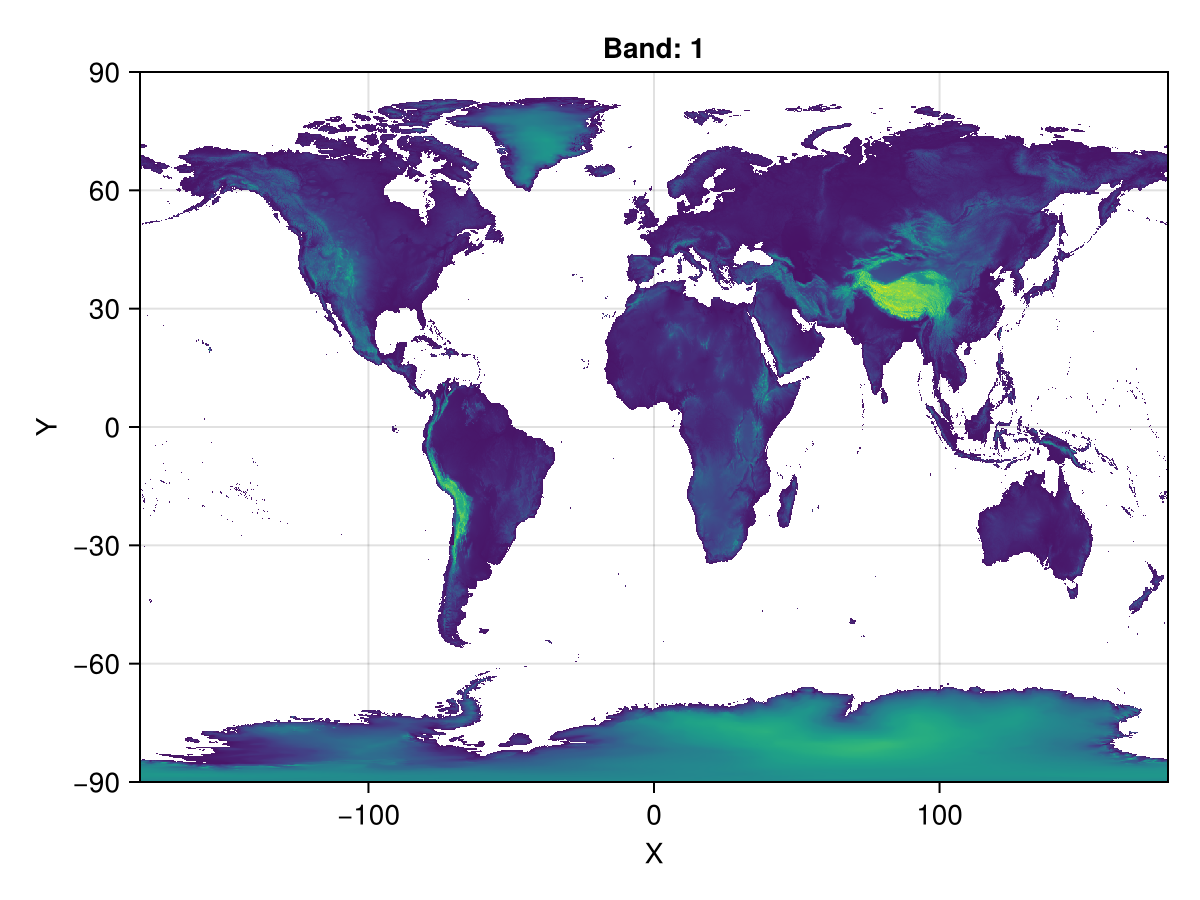

In [16]:
using CairoMakie
plot(elev)

Looks okay, but it doesn't tell us what units this data has, for example. Let's look for the highest and lowest point on the planet

In [17]:
extrema(elev)

(missing, missing)

Because some of the cells are have missing values, we need to wrap our raster in `skipmissing` so missing values are ignored

In [18]:
extrema(skipmissing(elev))

(-352, 6251)

Interestingly, some areas of the world are below see level. We can use broadcasting to identify cells that have values below 0

In [19]:
below_sea_level = elev .< 0

┌ 2160×1080 Raster{Union{Missing, Bool}, 2} ┐
├───────────────────────────────────────────┴──────────────────────────── dims ┐
  ↓ X Projected{Float64} -180.0:0.16666666666666666:179.83333333333331 ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} 89.83333333333333:-0.16666666666666666:-90.0 ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 1 entry:
  "filepath" => ".\\WorldClim\\Elevation\\wc2.1_10m_elev.tif"
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (-180.0, 179.99999999999997), Y = (-90.0, 90.0))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘
    ↓ →    89.8333    89.6667    …  -89.5  -89.6667  -89.8333  -90.0
 -180.0      missing    missing       0 

This created a Raster with `true` and `false` values. We can again explore and visualize this Raster.

How many pixels are below sea level?

In [20]:
count(skipmissing(below_sea_level))

2691

In julia, functions like mean, sum, and count can take a function as their first argument, which is applied to each element before taking the mean/sum/count. So an alternative way to do this is:

In [21]:
count(<(0), skipmissing(elev)) # count values in `elev` that are below 0

2691

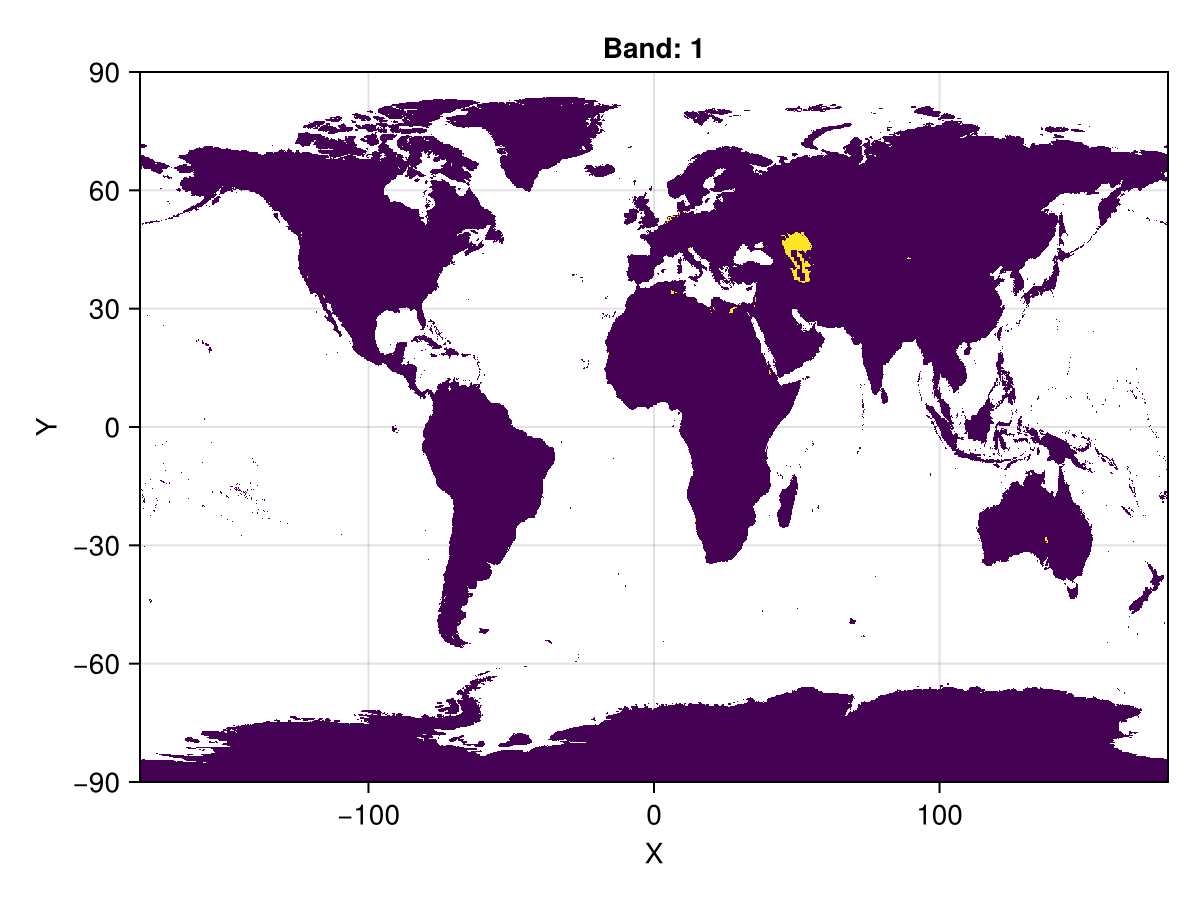

In [22]:
plot(below_sea_level)

## Exercise:
Explore this data a little more. **How many pixels are above 5000 meters? Where are they?**

<details><summary>Click to show an answer</summary>

First generate a Raster with boolean values

`over_5000_m = elev .> 5000`

Then count true values

`count(skipmissing(over_5000_m))`

The plot this

`plot(over_5000_m)`
</details>

**What is the average elevation across all grid cells?**
<details><summary>Click to show an answer</summary>

`mean(skipmissing(elev))`
</details>


**Which pixel has the highest elevation of all? What are the coordinates of that pixel?**

You will probably need some help from either Google or the Rasters documentation.

<details><summary>Click to show some tips</summary>

First use the `argmax` function to identify the index of the cell with highest value. You can also use `findmax` to get both the value and the index of that cell.

`DimPoints` returns a Raster with the coordinate locations of all Raster cells. Use the index you got to select the cell that has the highest value.
</details>

<details><summary>Click to show an answer</summary>

`DimPoints(elev)[argmax(skipmissing(elev))]`
</details>

Our previous estimate of the average elevation is flawed, because we did not account for differences in the area of each grid cell. **Come up with a better estimate of the average elevation, taking into account the cell area of each grid cell**. 

Hint: the `cellarea` function computes the cell area (in metres^2) of every grid cell

In [23]:
# Your answers go here. Feel free to make additional cells

# Explore the elevation of Kenya

For the next part of this tutorial, we'll analyse Raster data for Kenya.

First, let's read in some administrative data for Kenya using the GADM package.

In [24]:
import GADM
kenya = GADM.get("KEN")

GADM.Table{Vector{Any}, WellKnownText{GeoFormatTypes.CRS}}(Any[Feature
  (index 0) geom => MULTIPOLYGON
  (index 0) GID_0 => KEN
  (index 1) COUNTRY => Kenya
], WellKnownText{GeoFormatTypes.CRS}(GeoFormatTypes.CRS(), "GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AXIS[\"Latitude\",NORTH],AXIS[\"Longitude\",EAST],AUTHORITY[\"EPSG\",\"4326\"]]"))

## Masking

Now let's use the `mask` function so we only select Kenya out of the original raster.

The mask function in Rasters takes a Raster as its first positional argumet, and can take one or multiply geometry/ies or another Raster as a keyword argument `with`.

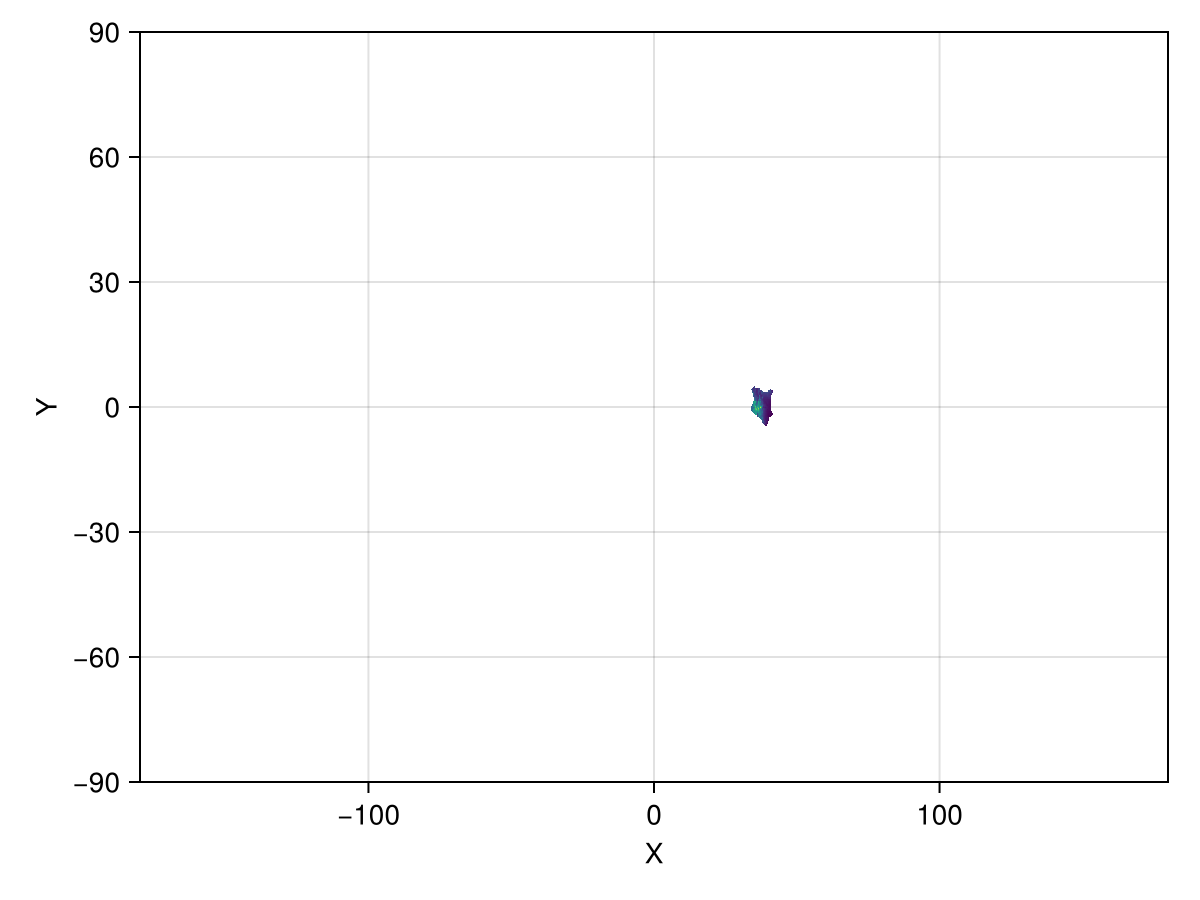

In [25]:
elev_kenya = mask(elev; with = kenya)
plot(elev_kenya)

## Cropping
This worked, but our Raster still has its initial size. To get rid of all of the missing values we can use `trim`


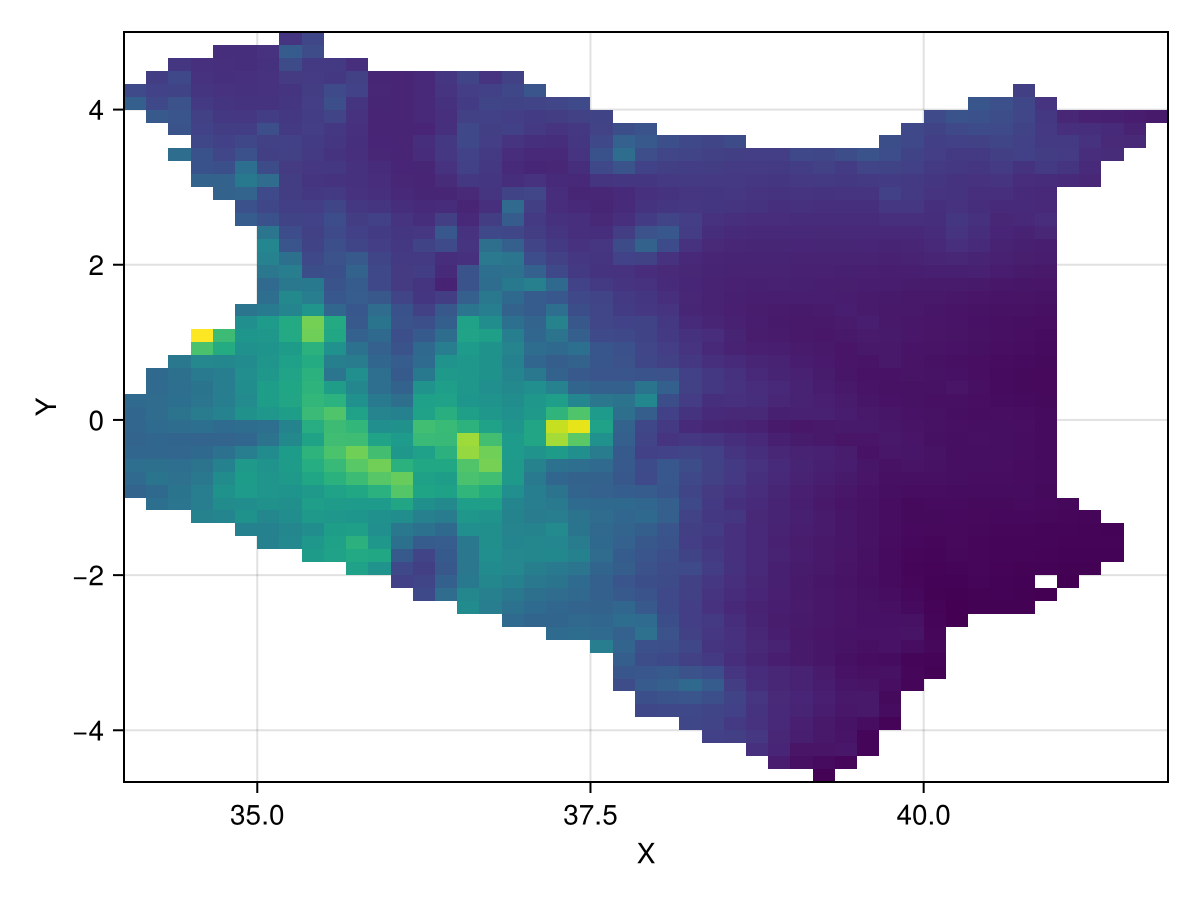

In [26]:
elev_kenya_trim = Rasters.trim(elev_kenya)
plot(elev_kenya_trim)

We can also just crop with the `crop` function. This takes a `to` keyword.

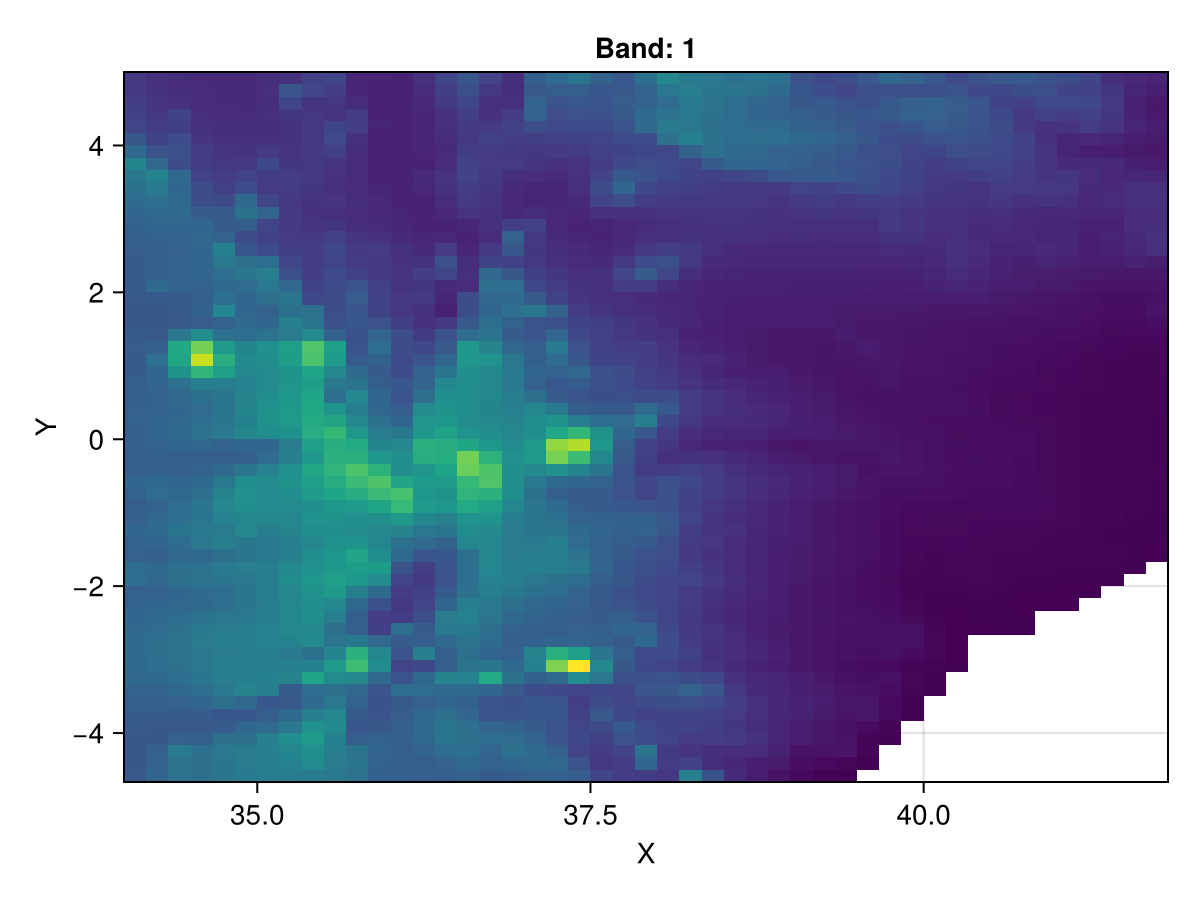

In [27]:
crop(elev; to = kenya) |> plot

# Elevation of all counties in Kenya
Let's do something a little bit more advanced with this elevation data.

Maybe we're interested in summarizing this data by showing the elevation of each county in Kenya.

We start of by using GADM again, but now with a depth argument that says we want the 1st level of adminstrative regions (counties).

We store this in a DataFrame so we can look at it more easily.

In [28]:
kenya_counties = GADM.get("KEN"; depth = 1) |> DataFrame

Row,geom,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1
,IGeometr…,String,String,String,String,String,String,String,String,String,String,String
1,Geometry: wkbMultiPolygon,KEN.1_1,KEN,Kenya,Baringo,NA,NA,County,County,30,KE.BA,KE-01
2,Geometry: wkbMultiPolygon,KEN.2_1,KEN,Kenya,Bomet,NA,NA,County,County,36,KE.BO,KE-02
3,Geometry: wkbMultiPolygon,KEN.3_1,KEN,Kenya,Bungoma,NA,NA,County,County,39,KE.BN,KE-03
4,Geometry: wkbMultiPolygon,KEN.4_1,KEN,Kenya,Busia,NA,NA,County,County,40,KE.BS,KE-04
5,Geometry: wkbMultiPolygon,KEN.5_1,KEN,Kenya,Elgeyo-Marakwet,NA,NA,County,County,28,KE.EM,NA
6,Geometry: wkbMultiPolygon,KEN.6_1,KEN,Kenya,Embu,NA,NA,County,County,14,KE.EB,KE-06
7,Geometry: wkbMultiPolygon,KEN.7_1,KEN,Kenya,Garissa,NA,NA,County,County,7,KE.GA,KE-07
8,Geometry: wkbMultiPolygon,KEN.8_1,KEN,Kenya,Homa Bay,NA,NA,County,County,43,KE.HB,KE-08
9,Geometry: wkbMultiPolygon,KEN.9_1,KEN,Kenya,Isiolo,NA,NA,County,County,11,KE.IS,KE-09


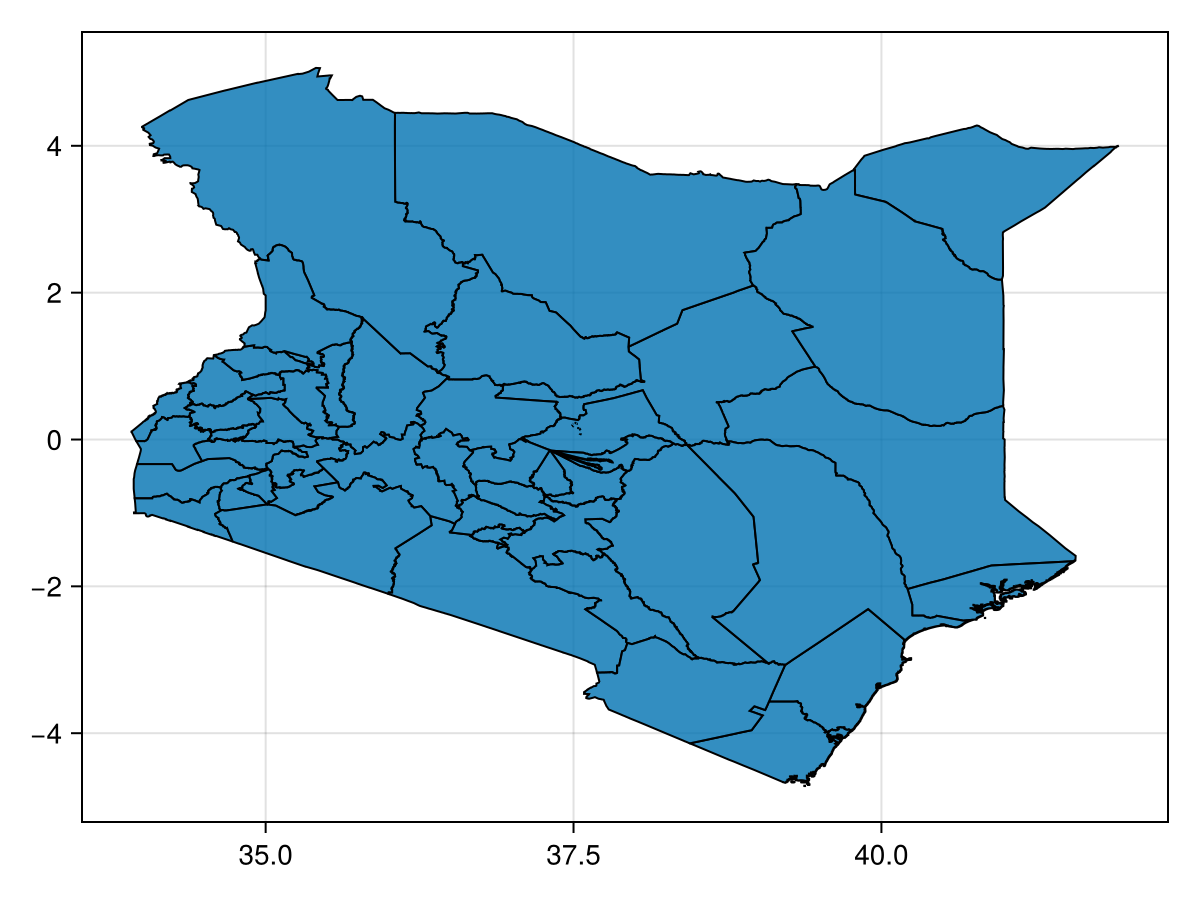

In [29]:
plot(kenya_counties.geom, strokewidth = 1)

Now, we use the `zonal` function from the Rasters package to summarize our elevation raster using a function we provide (here: `mean`) for each of the counties. We store this in a new column of the DataFrame.

Zonal has 3 obligatory arguments:
- The first positional argument is a function used to calculate the zonal statistic
- The second positional argument is the Raster
- The `of` keyword argument is an iterable (e.g. vector) with geometries

In [30]:
using Statistics: mean
kenya_counties.elevation = zonal(mean, elev; of = kenya_counties.geom)
kenya_counties

Applying mean to each geometry... 100%|██████████████████████████████████████████████████| Time: 0:00:00


Row,geom,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,elevation
,IGeometr…,String,String,String,String,String,String,String,String,String,String,String,Float64?
1,Geometry: wkbMultiPolygon,KEN.1_1,KEN,Kenya,Baringo,NA,NA,County,County,30,KE.BA,KE-01,1408.34
2,Geometry: wkbMultiPolygon,KEN.2_1,KEN,Kenya,Bomet,NA,NA,County,County,36,KE.BO,KE-02,2010.22
3,Geometry: wkbMultiPolygon,KEN.3_1,KEN,Kenya,Bungoma,NA,NA,County,County,39,KE.BN,KE-03,1934.8
4,Geometry: wkbMultiPolygon,KEN.4_1,KEN,Kenya,Busia,NA,NA,County,County,40,KE.BS,KE-04,1262.75
5,Geometry: wkbMultiPolygon,KEN.5_1,KEN,Kenya,Elgeyo-Marakwet,NA,NA,County,County,28,KE.EM,NA,1956.89
6,Geometry: wkbMultiPolygon,KEN.6_1,KEN,Kenya,Embu,NA,NA,County,County,14,KE.EB,KE-06,1272.62
7,Geometry: wkbMultiPolygon,KEN.7_1,KEN,Kenya,Garissa,NA,NA,County,County,7,KE.GA,KE-07,151.133
8,Geometry: wkbMultiPolygon,KEN.8_1,KEN,Kenya,Homa Bay,NA,NA,County,County,43,KE.HB,KE-08,1275.85
9,Geometry: wkbMultiPolygon,KEN.9_1,KEN,Kenya,Isiolo,NA,NA,County,County,11,KE.IS,KE-09,468.597


We can now sort this dataframe so it is ordered by elevation

In [31]:
# Sort to see which counties have low and high elevations.
sort!(kenya_counties, :elevation)

Row,geom,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,elevation
,IGeometr…,String,String,String,String,String,String,String,String,String,String,String,Float64?
1,Geometry: wkbMultiPolygon,KEN.21_1,KEN,Kenya,Lamu,NA,NA,County,County,5,KE.LM,KE-21,21.8571
2,Geometry: wkbMultiPolygon,KEN.28_1,KEN,Kenya,Mombasa,NA,NA,County,County,1,KE.MM,KE-28,43.0
3,Geometry: wkbMultiPolygon,KEN.14_1,KEN,Kenya,Kilifi,NA,NA,County,County,3,KE.KF,KE-14,140.921
4,Geometry: wkbMultiPolygon,KEN.7_1,KEN,Kenya,Garissa,NA,NA,County,County,7,KE.GA,KE-07,151.133
5,Geometry: wkbMultiPolygon,KEN.40_1,KEN,Kenya,Tana River,NA,NA,County,County,4,KE.TR,KE-40,209.354
6,Geometry: wkbMultiPolygon,KEN.19_1,KEN,Kenya,Kwale,NA,NA,County,County,2,KE.KW,KE-19,244.864
7,Geometry: wkbMultiPolygon,KEN.46_1,KEN,Kenya,Wajir,NA,NA,County,County,8,KE.WJ,KE-46,318.305
8,Geometry: wkbMultiPolygon,KEN.9_1,KEN,Kenya,Isiolo,NA,NA,County,County,11,KE.IS,KE-09,468.597
9,Geometry: wkbMultiPolygon,KEN.24_1,KEN,Kenya,Mandera,NA,NA,County,County,9,KE.MD,KE-24,559.184


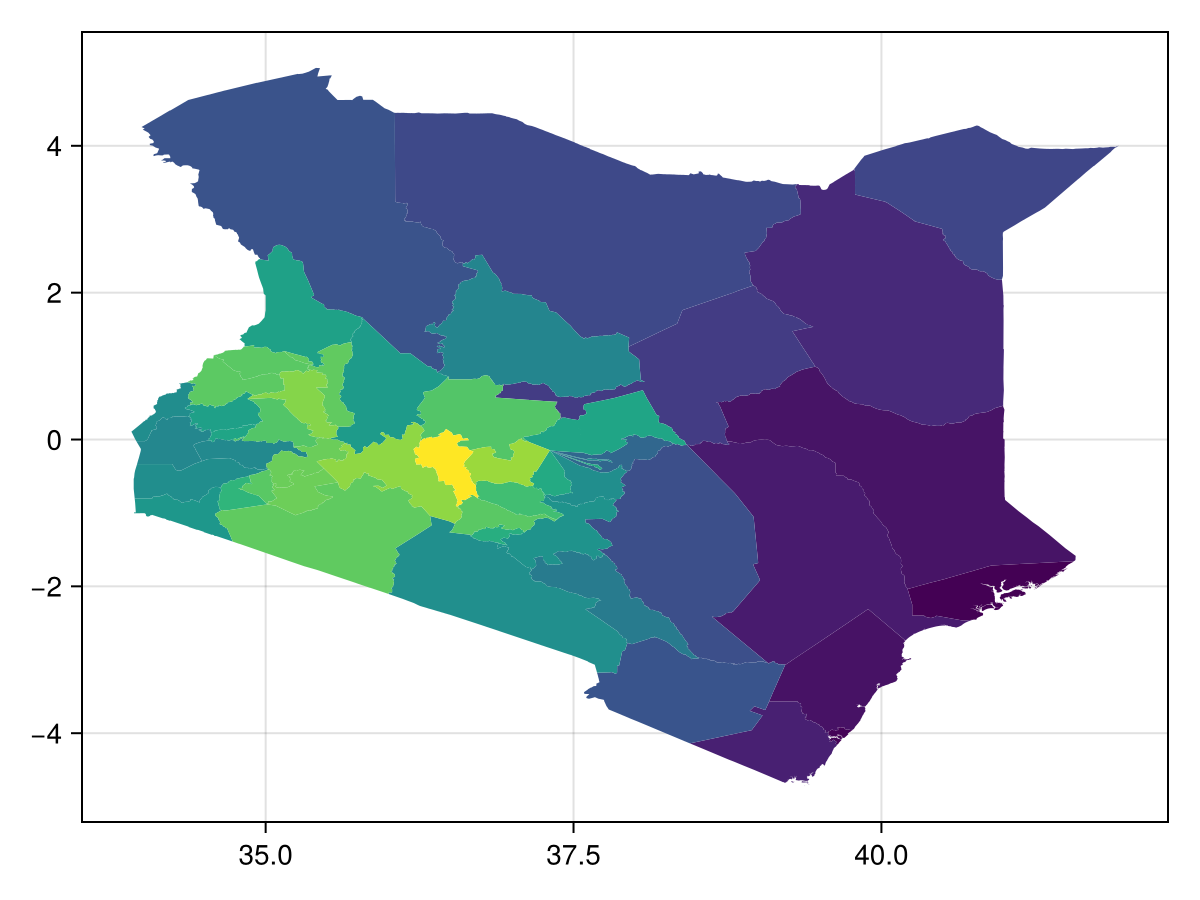

In [32]:
plot(kenya_counties.geom; color = Float64.(kenya_counties.elevation))

# RasterStack and RasterSeries

There are 2 other important Raster data structures: stacks and series.

Stacks of Rasters are a named collection of Rasters with some shared dimensions. If dimensions are shared between Rasters, they must be identical. Often, each layer in the stack represents some variable. Internally, these are stored as a NamedTuple of Rasters.

Series of Rasters are a collection of Rasters along some dimension - e.g. a time series. This can be useful if you have lots of files, for example with daily records. This is similar to an 'array of arrays' structure.

For both stacks and series, functions like crop and mask are applied to all rasters they contain. Functions like zonal and extract (more on extract later) are also implemented for stacks.

In [49]:
bioc = RasterStack(WorldClim{Climate}, (:tavg, :prec, :srad); month = 1)

┌ Info: Starting download for https://geodata.ucdavis.edu/climate/worldclim/2_1/base/wc2.1_10m_tavg.zip
└ @ RasterDataSources C:\Users\tsh371\.julia\dev\RasterDataSources\src\shared.jl:64
┌ Info: Downloading
│   source = https://geodata.ucdavis.edu/climate/worldclim/2_1/base/wc2.1_10m_tavg.zip
│   dest = .\WorldClim\Climate\zips\wc2.1_10m_tavg.zip
│   progress = 0.006
│   time_taken = 1.13 s
│   time_remaining = 187.9 s
│   average_speed = 193.026 KiB/s
│   downloaded = 218.699 KiB
│   remaining = 35.420 MiB
│   total = 35.634 MiB
└ @ HTTP C:\Users\tsh371\.julia\packages\HTTP\MIUdD\src\download.jl:132
┌ Info: Downloading
│   source = https://geodata.ucdavis.edu/climate/worldclim/2_1/base/wc2.1_10m_tavg.zip
│   dest = .\WorldClim\Climate\zips\wc2.1_10m_tavg.zip
│   progress = 0.0996
│   time_taken = 2.28 s
│   time_remaining = 20.6 s
│   average_speed = 1.557 MiB/s
│   downloaded = 3.548 MiB
│   remaining = 32.086 MiB
│   total = 35.634 MiB
└ @ HTTP C:\Users\tsh371\.julia\packages\HTTP\

┌ 2160×1080 RasterStack ┐
├───────────────────────┴──────────────────────────────────────────────── dims ┐
  ↓ X Projected{Float64} -180.0:0.16666666666666666:179.83333333333331 ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} 89.83333333333333:-0.16666666666666666:-90.0 ReverseOrdered Regular Intervals{Start}
├────────────────────────────────────────────────────────────────────── layers ┤
  :tavg eltype: Union{Missing, Float32} dims: X, Y size: 2160×1080
  :prec eltype: Union{Missing, Int16} dims: X, Y size: 2160×1080
  :srad eltype: Union{Missing, UInt16} dims: X, Y size: 2160×1080
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (-180.0, 179.99999999999997), Y = (-90.0, 90.0))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘

In [50]:
# Indexing a RasterStack by layer names returns a Rasters
bioc.tavg

┌ 2160×1080 Raster{Union{Missing, Float32}, 2} tavg ┐
├───────────────────────────────────────────────────┴──────────────────── dims ┐
  ↓ X Projected{Float64} -180.0:0.16666666666666666:179.83333333333331 ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} 89.83333333333333:-0.16666666666666666:-90.0 ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 1 entry:
  "filepath" => ".\\WorldClim\\Climate\\tavg\\wc2.1_10m_tavg_01.tif"
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (-180.0, 179.99999999999997), Y = (-90.0, 90.0))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘
    ↓ →    89.8333    89.6667    89.5       …  -89.6667  -89.8333  -90.0
 -180.0      missing 

In [58]:
bioc_series = RasterSeries(WorldClim{Climate}, (:tavg, :prec, :srad); month = 1:12)

┌ 12-element RasterSeries{RasterStack,1} ┐
├────────────────────────────────────────┴─────────────────────────────── dims ┐
  ↓ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (-180.0, 179.99999999999997), Y = (-90.0, 90.0))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘
  1  …  RasterStack{(:tavg, :prec, :srad), @NamedTuple{tavg::Union{Missing, Float32}, prec::Union{Missing, Int16}, srad::Union{Missing, UInt16}}, 2, @NamedTuple{tavg::ReshapedArray{Union{Missing, Float32}, 2, Array{Union{Missing, Float32}, 3}, Tuple{}}, prec::ReshapedArray{Union{Missing, Int16}, 2, Array{Union{Missing, Int16}, 3}, Tuple{}}, srad::ReshapedArray{Union{Missing, UInt16}, 2, Array{Union{Missing, UInt16}, 3}, Tuple{}}}, Tuple{X{Projected{Float64, StepRangeLen{Float64,

In [61]:
# We can mask as if this was a normal Raster
bioc_series_kenya = Rasters.trim(mask(bioc_series; with = kenya))

┌ 12-element RasterSeries{RasterStack,1} ┐
├────────────────────────────────────────┴─────────────────────────────── dims ┐
  ↓ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (33.999999999999986, 41.83333333333332), Y = (-4.666666666666667, 5.0))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘
  1  …  RasterStack{(:tavg, :prec, :srad), @NamedTuple{tavg::Union{Missing, Float32}, prec::Union{Missing, Int16}, srad::Union{Missing, UInt16}}, 2, @NamedTuple{tavg::SubArray{Union{Missing, Float32}, 2, Matrix{Union{Missing, Float32}}, Tuple{UnitRange{Int64}, UnitRange{Int64}}, false}, prec::SubArray{Union{Missing, Int16}, 2, Matrix{Union{Missing, Int16}}, Tuple{UnitRange{Int64}, UnitRange{Int64}}, false}, srad::SubArray{Union{Missing, UInt16}, 2, Matrix{

In [62]:
# We can combine RasterSeries into a single Raster
bioc_kenya = Rasters.combine(bioc_series_kenya)

┌ 47×58×12 RasterStack ┐
├──────────────────────┴───────────────────────────────────────────────── dims ┐
  ↓ X     Projected{Float64} 33.999999999999986:0.16666666666666666:41.66666666666666 ForwardOrdered Regular Intervals{Start},
  → Y     Projected{Float64} 4.833333333333333:-0.16666666666666666:-4.666666666666667 ReverseOrdered Regular Intervals{Start},
  ↗ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── layers ┤
  :tavg eltype: Union{Missing, Float32} dims: X, Y, month size: 47×58×12
  :prec eltype: Union{Missing, Int16} dims: X, Y, month size: 47×58×12
  :srad eltype: Union{Missing, UInt16} dims: X, Y, month size: 47×58×12
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (33.999999999999986, 41.83333333333332), Y = (-4.666666666666667, 5.0), month = (1, 12))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298

Other than bands in a single Raster, layer in a RasterStack can have different types. Here solar radiation is a UInt16 (unsigned integer), and temperature is a floating point number.

Not all bands have to share all dimensions - we can add a band that has the number of days per month.

In [75]:
days_per_month = Raster([31,30,31,28,31,30,31,31,30,31,30,31], Dim{:month}(1:12); name = :ndays)

┌ 12-element Raster{Int64, 1} ndays ┐
├───────────────────────────────────┴──────────────────────────────────── dims ┐
  ↓ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(month = (1, 12),)
└──────────────────────────────────────────────────────────────────────────────┘
  1  31
  2  30
  3  31
  4  28
  5  31
  6  30
  7  31
  8  31
  9  30
 10  31
 11  30
 12  31

In [ ]:
println("let's check we have the right number of days: $(sum(days_per_month))")
# make a new rasterstack with the layers of the old one, and a new raster
rs_kenya = RasterStack(layers(bioc_kenya)..., days_per_month)

let's check we have the right number of days: 365


┌ 47×58×12 RasterStack ┐
├──────────────────────┴───────────────────────────────────────────────── dims ┐
  ↓ X     Projected{Float64} 33.999999999999986:0.16666666666666666:41.66666666666666 ForwardOrdered Regular Intervals{Start},
  → Y     Projected{Float64} 4.833333333333333:-0.16666666666666666:-4.666666666666667 ReverseOrdered Regular Intervals{Start},
  ↗ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── layers ┤
  :tavg  eltype: Union{Missing, Float32} dims: X, Y, month size: 47×58×12
  :prec  eltype: Union{Missing, Int16} dims: X, Y, month size: 47×58×12
  :srad  eltype: Union{Missing, UInt16} dims: X, Y, month size: 47×58×12
  :ndays eltype: Int64 dims: month size: 12
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: (tavg = missing, prec = missing, srad = missing, ndays = nothing)
  extent: Extent(X = (33.999999999999986, 41.83333333333332), Y = (-4.6666

# Estimating fascioliasis risk in Kenya
Fascioliasis (liver fluke) is a snail-borne parasitic disease that affects cattle. 

[Malone et al. (1998)](10.1016/s0304-4017(98)00137-x) define a simple risk index for this disease:

$$
\text{riskindex} =
\begin{cases} 
\text{GDD} \cdot \text{days in month}, & \text{if } R > (PET \cdot 0.8) \\
\text{GDD} \cdot \text{days in month} + \frac{(\text{GDD} \cdot 6) \cdot (R - PET)}{25}, & \text{if } R > PET \\
0, & \text{otherwise}
\end{cases}
$$


where GDD is the number of Growing Degree Days, R is precipitation, and PET is potential evapotranspiration.

There are two species that cause liver fluke: _Fasciola hepatica_ and _Fasciola gigantica_. The GDD threshold for _F. hepatica_ is 10°C and for _F. gigantica_ it is 16°C.

High-risk zones might have monthly values above ~300.

WorldClim does not supply PET, but we can calculate it using the Hargreaves equation:
$$
PET = 0.0023 * (T_{mean} + 17.8) * \sqrt{T_{max} - T_{min}} * SR
$$

Where SR is solar radiation in MJ/m^2/day, and T is temperature in °C

To avoid having to download more data we will just assume that $T_{max} - T_{min}$ is 15

First we need to calculate PET. Let's define a function to calculate the Hargreaves equation

In [122]:
function hargreaves(sr, t; tdif = 10) 
    0.0023 * sr * (t + 17.8) * sqrt(tdif) # Hargreaves equation
end

hargreaves (generic function with 1 method)

In [101]:
daily_pet = hargreaves.(rs_kenya.srad ./ 1000, rs_kenya.tavg) # Hargreaves equation

┌ 47×58×12 Raster{Union{Missing, Float64}, 3} ┐
├─────────────────────────────────────────────┴────────────────────────── dims ┐
  ↓ X     Projected{Float64} 33.999999999999986:0.16666666666666666:41.66666666666666 ForwardOrdered Regular Intervals{Start},
  → Y     Projected{Float64} 4.833333333333333:-0.16666666666666666:-4.666666666666667 ReverseOrdered Regular Intervals{Start},
  ↗ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (33.999999999999986, 41.83333333333332), Y = (-4.666666666666667, 5.0), month = (1, 12))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1]
  ↓ →     4.83333   4.66667   4.5       …  -4.33333   -4.5       -4.66667
 34.0      missing   missing   missing       missing    missing    missing
 34.1667   missing   mis

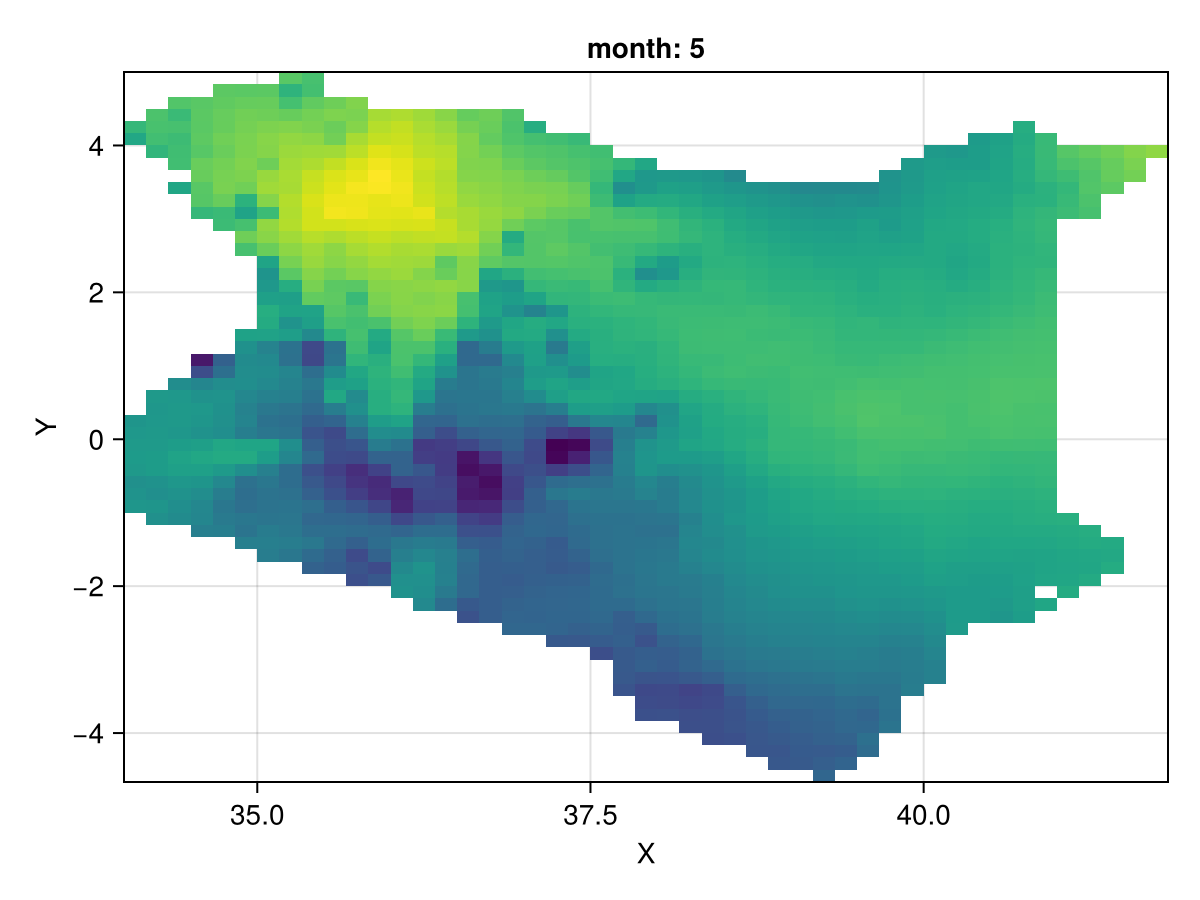

In [105]:
plot(daily_pet[month = 5])

We now need to correct for the number of days in each month - since our precipitation data is also per month.

We can do this by just multiplying the PET by the number of days in each month. To do this, we will use the `@d` macro before the broadcasted function. This ensures a "dimension-aware broadcast" and is necessary when broadcasting objects that have different dimensions.

Inside a macro we can sometimes use additional syntax; with `@d`, we can specify `name = :pet` as the name of the resulting Raster. 

In [115]:
monthly_pet = @d daily_pet .* rs_kenya.ndays name = :pet # multiply by number of days in month


┌ 47×58×12 Raster{Union{Missing, Float64}, 3} pet ┐
├─────────────────────────────────────────────────┴────────────────────── dims ┐
  ↓ X     Projected{Float64} 33.999999999999986:0.16666666666666666:41.66666666666666 ForwardOrdered Regular Intervals{Start},
  → Y     Projected{Float64} 4.833333333333333:-0.16666666666666666:-4.666666666666667 ReverseOrdered Regular Intervals{Start},
  ↗ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (33.999999999999986, 41.83333333333332), Y = (-4.666666666666667, 5.0), month = (1, 12))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1]
  ↓ →     4.83333   4.66667     4.5       …  -4.33333   -4.5       -4.66667
 34.0      missing   missing     missing       missing    missing    missing
 34.1667   missi

In [116]:
mean(skipmissing(monthly_pet))

174.93679329926684

Let's visualize when and where precipitation meets the 0.8*PET threshold. We can use the Rasters.rplot function for some quick plotting of Rasters that have more than 2 dimensions (or for RasterStacks)

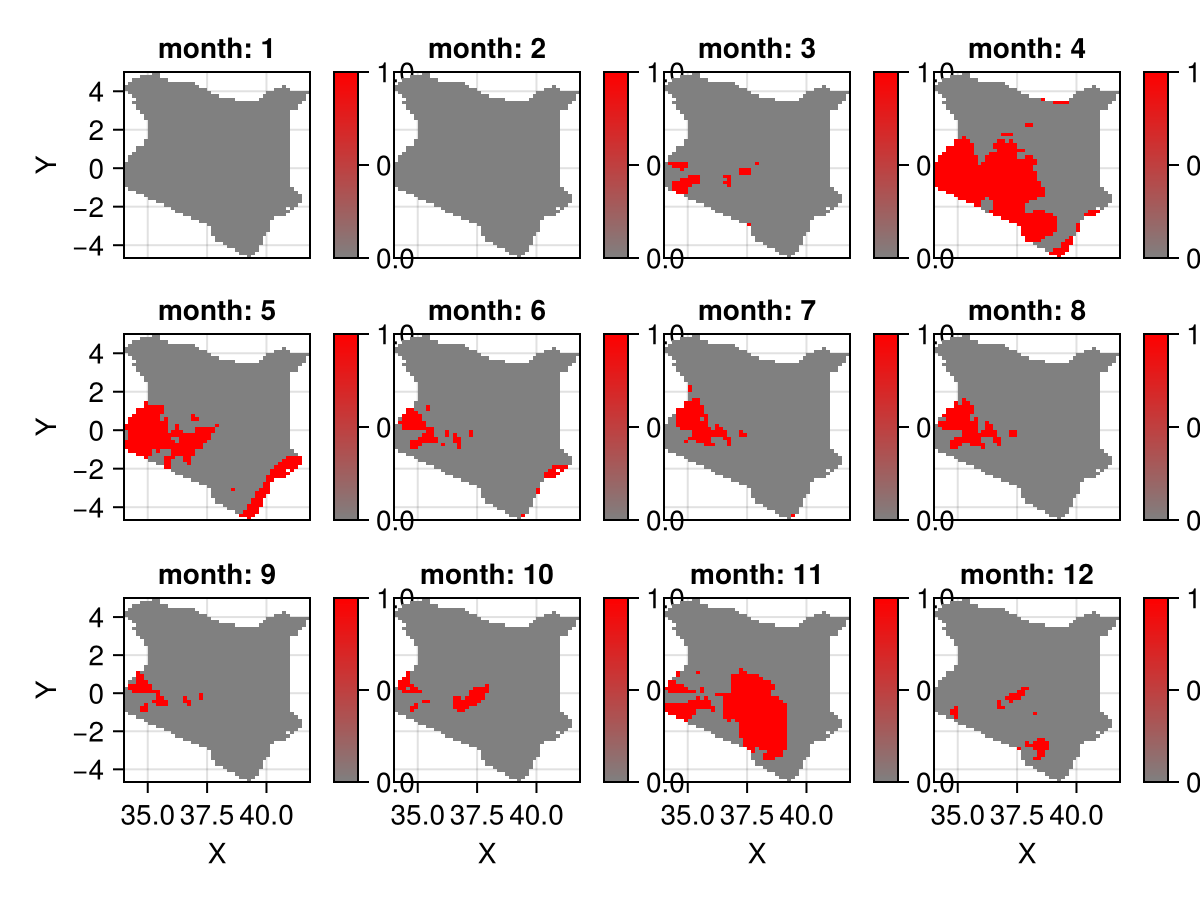

In [120]:
Rasters.rplot(rs_kenya.prec .> monthly_pet .* 0.8, colorrange = (0,1), colormap = [:grey, :red])

In [121]:
risk_inputs = RasterStack(layers(rs_kenya)..., monthly_pet)

┌ 47×58×12 RasterStack ┐
├──────────────────────┴───────────────────────────────────────────────── dims ┐
  ↓ X     Projected{Float64} 33.999999999999986:0.16666666666666666:41.66666666666666 ForwardOrdered Regular Intervals{Start},
  → Y     Projected{Float64} 4.833333333333333:-0.16666666666666666:-4.666666666666667 ReverseOrdered Regular Intervals{Start},
  ↗ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── layers ┤
  :tavg  eltype: Union{Missing, Float32} dims: X, Y, month size: 47×58×12
  :prec  eltype: Union{Missing, Int16} dims: X, Y, month size: 47×58×12
  :srad  eltype: Union{Missing, UInt16} dims: X, Y, month size: 47×58×12
  :ndays eltype: Int64 dims: month size: 12
  :pet   eltype: Union{Missing, Float64} dims: X, Y, month size: 47×58×12
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: (tavg = missing, prec = missing, srad = missing, ndays = nothing, 

# Exercise

Make a monthly risk map for _Fasciola_ transmission in Kenya.

You will need to define a function that takes environmental variables as inputs and returns the risk index. Then, you should apply this function to every grid cell for Kenya.

What are areas at risk of Fascioliasis?

In [141]:
function fasc(prec, pet, tavg, days_in_month; gdd_threshold = 16)
    if ismissing(prec)
        return missing
    end
    index = 0.0
    gdd = tavg - gdd_threshold
    if gdd > 0 && prec > pet * 0.8
        index += days_in_month*gdd
        if prec > pet
            index += (gdd*6)*(prec-pet)/25
        end
    end
    return index
end

fasc(nt::NamedTuple) = fasc(nt.prec, nt.pet, nt.tavg, nt.ndays)

fasc (generic function with 2 methods)

In [148]:
risk_inputs.tavg |> skipmissing |> mean

24.309313f0

In [143]:
gigantica_risk = rebuild(first(layers(risk_inputs)), data = fasc.(risk_inputs))

┌ 47×58×12 Raster{Union{Missing, Float64}, 3} tavg ┐
├──────────────────────────────────────────────────┴───────────────────── dims ┐
  ↓ X     Projected{Float64} 33.999999999999986:0.16666666666666666:41.66666666666666 ForwardOrdered Regular Intervals{Start},
  → Y     Projected{Float64} 4.833333333333333:-0.16666666666666666:-4.666666666666667 ReverseOrdered Regular Intervals{Start},
  ↗ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (33.999999999999986, 41.83333333333332), Y = (-4.666666666666667, 5.0), month = (1, 12))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1]
  ↓ →     4.83333   4.66667   4.5       …  -4.33333   -4.5       -4.66667
 34.0      missing   missing   missing       missing    missing    missing
 34.1667   missing 

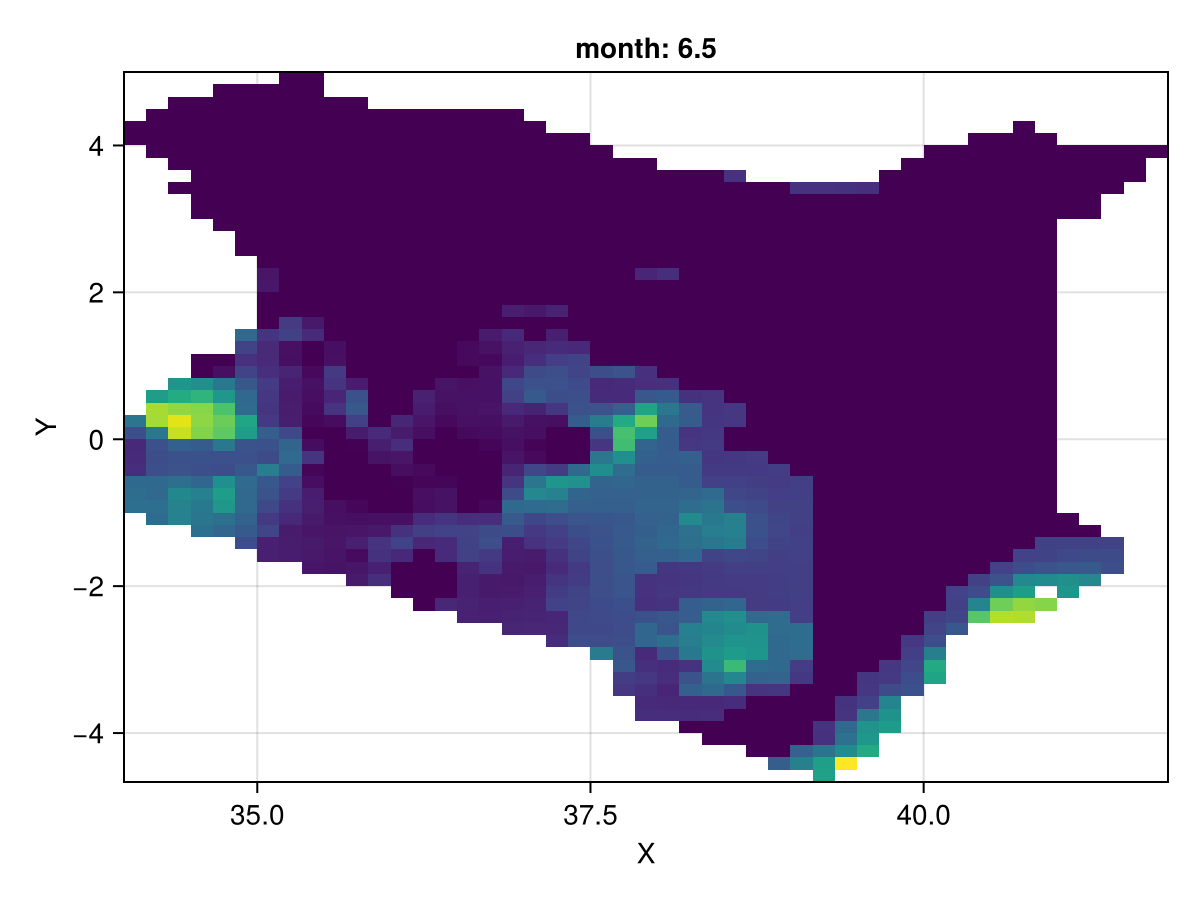

In [151]:
dropdims(sum(gigantica_risk; dims = :month); dims = :month) |> plot	

In [144]:
extrema(skipmissing(gigantica_risk))

(0.0, 895.536973808596)

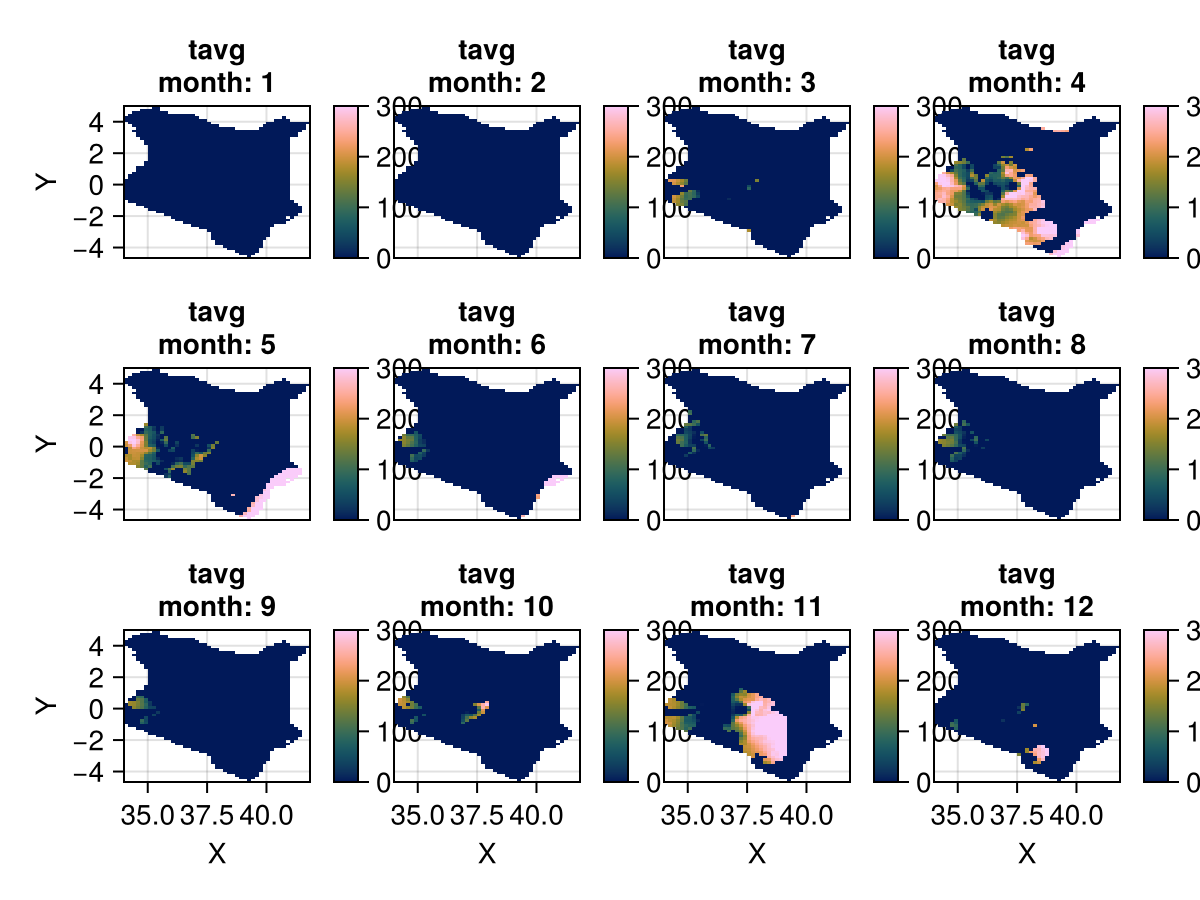

In [147]:
Rasters.rplot(gigantica_risk, colorrange = (0,300))

# Eager and lazy loading
One key feature of the Rasters package is that it can easily handle data without ever looking at them - this is known as lazy operations.

For example, you could have a huge dataset on the web or on your computer, that you only want to download a little bit of, or that is just to big to fit in RAM. If you load this data lazily, you can look at it and even change it, but the operations only happen when needed (e.g. when calling `read`, when plotting, or when writing to disk).

Let's download a bigger dataset with global temperatures, but since we'll only look at Kenya, we'll load it lazily.

In [36]:
tavg = Raster(WorldClim{BioClim}, :bio1; res = "2.5m", lazy = true)

┌ Info: Starting download for https://geodata.ucdavis.edu/climate/worldclim/2_1/base/wc2.1_2.5m_bio.zip
└ @ RasterDataSources C:\Users\tsh371\.julia\dev\RasterDataSources\src\shared.jl:64
┌ Info: Downloading
│   source = https://geodata.ucdavis.edu/climate/worldclim/2_1/base/wc2.1_2.5m_bio.zip
│   dest = .\WorldClim\BioClim\zips\wc2.1_2.5m_bio.zip
│   progress = 0.0003
│   time_taken = 1.14 s
│   time_remaining = 3347.54 s
│   average_speed = 192.008 KiB/s
│   downloaded = 218.697 KiB
│   remaining = 627.691 MiB
│   total = 627.904 MiB
└ @ HTTP C:\Users\tsh371\.julia\packages\HTTP\MIUdD\src\download.jl:132
┌ Info: Downloading
│   source = https://geodata.ucdavis.edu/climate/worldclim/2_1/base/wc2.1_2.5m_bio.zip
│   dest = .\WorldClim\BioClim\zips\wc2.1_2.5m_bio.zip
│   progress = 0.0056
│   time_taken = 2.27 s
│   time_remaining = 400.03 s
│   average_speed = 1.561 MiB/s
│   downloaded = 3.548 MiB
│   remaining = 624.357 MiB
│   total = 627.904 MiB
└ @ HTTP C:\Users\tsh371\.julia\packa

┌ 8640×4320 Raster{Union{Missing, Float32}, 2} bio1 ┐
├───────────────────────────────────────────────────┴──────────────────── dims ┐
  ↓ X Projected{Float64} -180.0:0.041666666666666664:179.95833333333331 ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} 89.95833333333333:-0.041666666666666664:-90.0 ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 1 entry:
  "filepath" => ".\\WorldClim\\BioClim\\wc2.1_2.5m_bio_1.tif"
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (-180.0, 179.99999999999997), Y = (-90.0, 90.0))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
  filename: .\WorldClim\BioClim\wc2.1_2.5m_bio_1.tif
└──────────────────────────────────────────────────────────────────────────────┘


First we will crop this Raster to get only the data we need

In [37]:
tavg_cropped = crop(tavg; to = kenya)

┌ 192×234 Raster{Union{Missing, Float32}, 2} bio1 ┐
├─────────────────────────────────────────────────┴────────────────────── dims ┐
  ↓ X Projected{Float64} 33.91666666666666:0.041666666666666664:41.874999999999986 ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} 5.0:-0.041666666666666664:-4.708333333333333 ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 1 entry:
  "filepath" => ".\\WorldClim\\BioClim\\wc2.1_2.5m_bio_1.tif"
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (33.91666666666666, 41.91666666666665), Y = (-4.708333333333333, 5.041666666666667))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
  filename: .\WorldClim\BioClim\wc2.1_2.5m_bio_1.tif
└──────────────────────────────────────────────────────────────────────────────┘


Now we read in only this data, and mask out kenya

In [38]:
tavg_kenya = mask(Base.read(tavg_cropped); with = kenya)

┌ 192×234 Raster{Union{Missing, Float32}, 2} ┐
├────────────────────────────────────────────┴─────────────────────────── dims ┐
  ↓ X Projected{Float64} 33.91666666666666:0.041666666666666664:41.874999999999986 ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} 5.0:-0.041666666666666664:-4.708333333333333 ReverseOrdered Regular Intervals{Start}
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (33.91666666666666, 41.91666666666665), Y = (-4.708333333333333, 5.041666666666667))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘
  ↓ →     5.0       4.95833   4.91667   …  -4.625     -4.66667   -4.70833
 33.9167   missing   missing   missing       missing    missing    missing
 33.9583   missing   missing   missing       missing    missing    missing
 34.0      missing   missing   missing       